In [181]:
### STEP 2 ###
from glob import glob
import os
import librosa
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

loc = './pr_lab1_2020-21_data/digits'

'''
parse_free_digits(loc)'''

def data_parser(directory):
    files = glob(os.path.join(directory, "*.wav"))
    fnames = [f.split('/')[3].split('.')[0] for f in files]
    ## extract ids from filename
    ids = [int(f[-2]+f[-1]) if f[-2].isdigit() else int(f[-1]) for f in fnames]
    ## extract float arrays of signals
    waves = [librosa.load(fpath,sr=None)[0] for fpath in files]
    ## extract digits from filenames
    digits = []
    for i in range(len(fnames)):
        if str(ids[i]) in fnames[i]:
            fnames[i] = fnames[i].replace(str(ids[i]),'')
    return waves, ids, fnames


In [164]:
### STEP 3 ###

waves,_,_ = data_parser(loc)

def extract_features(waves,num_mfcc=13,window=25,step=10):
    '''
    returns list of np.arrays of shape (frames of signal x num_mfcc)
    '''
    w = window*16000//1000 ## length of window in Hz
    s = step*16000//1000  ## length of step in Hz
    mfccs = [
        librosa.feature.mfcc(y=wav,n_mfcc=num_mfcc,n_fft=w,hop_length=w-s).T ## by default returns (MFCC x Waves) shape
        for wav in tqdm(waves, desc='Extracting MFCC features...')
    ]
    deltas = [librosa.feature.delta(mfcc) for mfcc in mfccs]
    ddeltas = [librosa.feature.delta(d) for d in mfccs]
    
    #print(mfccs[0].shape,deltas[0].shape,ddeltas[0].shape)
    
    print(f'Feature extraction completed: {num_mfcc} MFCC per frame.')
    return mfccs, deltas, ddeltas

#extract_features(waves)


In [152]:
### STEP 4 ### 
''''
MFCS not yet extracted.
'''
loc = './pr_lab1_2020-21_data/digits'
waves,ids,digits = data_parser(loc)
mfccs, deltas, ddeltas = extract_features(waves)

def find_indices(list,item):
    indices = []
    for idx, value in enumerate(list):
        if value == item:
            indices.append(idx)
    return indices

def find_mfccs(mfccs,ids,n1=1,n2=2):
    ## find indices of speakers
    n1_indices = find_indices(ids,n1)
    n2_indices = find_indices(ids,n2)
    
    n1_mffcs = []
    for i in n1_indices:
        n1_mffcs.append(mfccs[i][0])
        n1_mffcs.append(mfccs[i][1])
        
    n2_mffcs = []
    for i in n2_indices:
        n2_mffcs.append(mfccs[i][0])
        n2_mffcs.append(mfccs[i][1])
        
    plt.hist(np.array(n1_mffcs))
    plt.show()
    plt.hist(np.array(n2_mffcs))
    plt.show()
    
    return n1_mffcs, n2_mffcs
    
    
def extract_mfsc(waves,ids,n1,n2):
    n1_indices = find_indices(ids,n1)
    n2_indices = find_indices(ids,n2)
    

#find_mfccs(mfccs,ids,n1=1,n2=2)

Extracting MFCC features...:   0%|          | 0/133 [00:00<?, ?it/s]

Extracting MFCC features...: 100%|██████████| 133/133 [00:00<00:00, 141.00it/s]


Feature extraction completed: 13 MFCC per frame.


In [169]:
### STEP 5 ###
loc = './pr_lab1_2020-21_data/digits'
waves,ids,digits = data_parser(loc)
mfccs, deltas, ddeltas = extract_features(waves)

def concat_features(feat1,feat2,feat3):
    res = []
    for m,d,dd in zip(feat1,feat2,feat3):
        res.append(np.concatenate((m,d,dd),axis=1))
    return res

res = concat_features(mfccs,deltas,ddeltas)
res[0].shape

Extracting MFCC features...:   0%|          | 0/133 [00:00<?, ?it/s]

/home/dimitris/.local/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Extracting MFCC features...: 100%|██████████| 133/133 [00:00<00:00, 226.98it/s]


Feature extraction completed: 13 MFCC per frame.


(53, 39)

four
nine
seven
one
eight
six
five
three
two


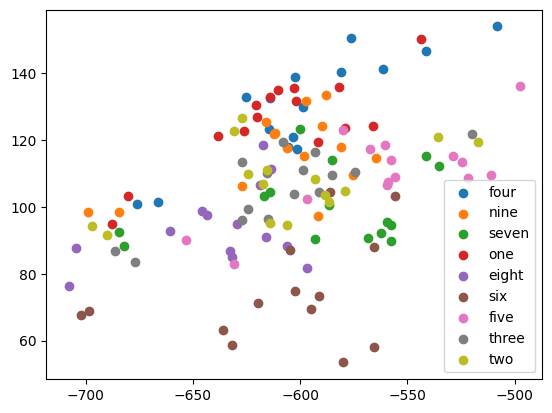

In [180]:
def mean_var_feat(feat,digits):
    '''
    MY IMPLEMENTATION (this might change)
    For every wave of each digit, find a seperate mean vector: each value is the mean of the selected feature over all time steps
    And a separate variance vector (variance of selected feature over all time steps)
    Lastly, concatenate those 2 vector into one.
    ''' 
    dig2vec = {} ## for each digit it contains all produced feature vectors in a list-> useful in scatter plot
    for idx,dig in enumerate(digits):
        mean = np.mean(feat[idx],axis=0)
        var = np.var(feat[idx],axis=0)
        vec = np.concatenate((mean,var),axis=0)
        if dig not in dig2vec.keys():
            dig2vec[dig] = [vec]
        else:
            dig2vec[dig].append(vec)
    
    return dig2vec

dict = mean_var_feat(mfccs,digits=digits)

def scatter(dict):
    f = plt.figure
    for digit in dict.keys():
        print(digit)
        x,y = [], []
        for vec in dict[digit]:
            x.append(vec[0])
            y.append(vec[1])
        plt.scatter(x,y)
    plt.legend(dict.keys())
    plt.show()
        
scatter(dict)       

In [188]:
### STEP 6 ###
def pca(dict):
    '''
    Input: dictionary containing all feature vectors per digit
    Output: dictionary containing all feature vectors per digit with dimension (2,1)
    '''
    pca = PCA()
    new_dict = {}
    for digit in dict.keys():
        mat = np.array(dict[digit])
        pca.fit(mat)
        variances = list(pca.explained_variance_ratio_)## get the variance of each index from PCA
        max2 = 0 ## find the 2 indexes with the greatest variance
        max1 = max(variances)
        for i in variances:
            if i>= 0 and i>=max2 and i != max1:
                max2 = i
            if  >= max2 and i != max1:
                max2 = i
        idx1 = variances.index(max1)
        idx2 = variances.index(max2)
        
        ## extract idx1-2 items from original vectors
        for vec in dict[digit]:
            new_vec = [vec[idx1],vec[idx2]]
            if digit not in new_dict.keys():
                dict[digit] = [new_vec]
            else:
                dict[digit].append(new_vec)
                
    return new_dict

new_dict = pca(dict=dict)
scatter(new_dict)  

/home/dimitris/.local/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ = (S**2) / (n_samples - 1)


ValueError: 0 is not in list